Sequential Monte Carlo is a general class of methods designed to sample sequentially from a sequence of target densities. State-space models is an example of a class of models that naturally have a sequence of target densities, if we're interested in latent-state estimation.

For me, Sequential Monte Carlo is the epitome of "the math is confusing but the idea is simple", so this post will take a stab at distilling the idea with math and code. 


## Overall Problem 

I find that the combination of math and code makes algorithms much easier to understand, so here's the math. I'll mainly follow the notation from [this](https://www.stats.ox.ac.uk/~doucet/doucet_defreitas_gordon_smcbookintro.pdf) paper, but will only write down the neccessities. 

The latent states, $X_t$ are modelled as a Markov process with initial state $p(x_0)$ and transition equation $p(x_t \mid x_{t-1})$. The observed data, $Y_t$, is assumed to be conditionally independent given the hidden state at time $t$, $X_t$, and has density $p(Y_t \mid X_t)$. The model is completely specified by the following: 

$$
\begin{aligned}
X_0 \sim p(x_0) & \qquad \qquad \text{Initial state} \\
p(X_t \mid X_{t-1}) &  \qquad \qquad \text{Transition density} \\
p(Y_t \mid X_t) & \qquad \qquad \text{Marginal of $Y_t \mid X_t$?}
\end{aligned}
$$

The aim is to estimate the posterior distribution of the latent states, $p(X_t \mid Y_t)$, which we use the bootstrap particle filter for. 


The bones of these notes come from [here](https://ib.berkeley.edu/labs/slatkin/eriq/classes/guest_lect/mc_lecture_notes.pdf), and I've adapted it a bit to help myself understand the concepts. 

## Setting the stage

We're interested in finding the expecation of some distribution, $f(x)$. This seems pretty general, but many useful quantities can be expressed as expectations, for example: 

- Probabilities are expectations of indicator functions:

$$ P(X = A) = E(I_A(X) $$

- Definite integrals between $[a, b]$ can be expressed as expectations over Uniform random variables. Say we want to integrate a function, $q(x)$ between $[a, b]$. Starting with the expected value of $X \sim U(a, b)$:

$$ E(q(X_u)) = \int_b^a q(x) \frac{1}{b-a} dx $$

$$ \int_b^a q(x) dx = (b-a)E(q(X_u)) $$


## Monte Carlo Estimates

The general idea here is to generate samples from a distribution that is easy to sample from, like $X \sim U(0,1)$. Then transform these samples using out function of interest, $q(x)$, and find the average of these values. 

Immediately, a problem arises which is that the distribution we sample from needs to be close-ish to the function of interest, or the method will be inefficient. This is where importance sampling comes in.


## Importance Sampling

The problem we are trying to solve with importance sampling is that during our Monte Carlo estimation scheme, the choice of sample distribution can throw off our estimates. IS deals with this problem by re-weighting the proposed samples to be closer in density to the function of interest. It does this re-weighting by multiplying the integrand "by 1". For example, we are interested in computing the integral of $g(x)$ in a region, $A$. Let $X \sim h(x)$ be a density where $\int_{x \in A} h(x) dx = 1$. Then we have: 

$$ \int_{x \in A} g(x) dx = \int_{x \in A} g(x) \frac{h(x)}{h(x)} dx $$

$$ \int_{x \in A} g(x) \frac{h(x)}{h(x)} dx = E_h(\frac{g(x)}{h(x)} $$

Then our Monte Carlo estimate for $g(x)$ is: 

$$ \frac{1}{N} \sum_{i = 1}^N \frac{g(x)}{h(x)}, \quad \quad \text{for: } X_i \sim h(x) $$


To be continued...

## Sequential Monte Carlo (Bootstrap Particle Filter)

In the bootstrap particle filter, we use the transition density as the proposal density in the importance samling step.

Model:

$$ x_t = \frac{1}{2}x_{t-1} + \frac{25x_{t-1}}{1 + x_{t-1}^2} + 8cos(1.2t) + v_t $$

$$ y_t = \frac{x_t^2}{20} + w_t $$

$$ x_0 \sim N(0, \sigma_1^2) $$

$$ w_t \sim N(0, 1) $$

$$ v_k \sim N(0, \sigma_k^2) $$


Outline of SMC algorithm: 

* Initialization: 
    * For $i = 1, ..., N$, sample $x_0^{(i)} \sim p(x_0)$ and set $t = 1$.
    
* Importance sampling step: 
    * For $i = 1, ..., N$, sample $x_t \sim p(x_t \mid x_{t-1}^{(i)})$ and inlcude in $x_{0:t}$
    * For $i = 1, ..., N$, evaluate the importance weights:
    $$ w_t^{(i)} = p(y_t \mid x_t^{(i)}) $$
    * Normalize importance weights
    
* Selection step: 
    * Resample with replacement $N$ particles $(x_{0:t}^{(i)}, i = 1, ..., N)$ according to $w_t^{(i)}$

In [41]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from numpy.random import uniform
from numpy.random import seed
from numpy.random import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [186]:
def transition (x, t):
    """ transition funciton from x_t to x_t+1 """
    if type(x) == np.float64 or type(x) == int:
        n_v = 1
    else : 
        n_v = len(x)
    v = norm(loc = 0, scale = np.sqrt(10)).rvs(size=n_v)
    return 0.5*x + ((25*x)/(1 + x**2)) + 8*np.cos(1.2*t) + v

def marginal_distribution (x):
    """ forward samping marginal for y_t | x_t """
    w = norm.rvs(size=1)
    return ((x**2)/ 20) + w

def conditional_marginal (y, x):
    """ conditional marginal y_t | x_t """
    y_x = norm(loc = ((x**2)/20), scale = 1)
    return y_x.pdf(y)
    
def step (T, x0, transition, marginal):
    """ step through T times """
    x = np.zeros(T)
    x[0] = x0
    y = np.zeros(T)
    y[0] = marginal(x[0])
    for t in range(1, T):
        x[t] = transition(x[t-1], t) 
        y[t] = marginal(x[t])
    return x, y

x_0 = norm(0, np.sqrt(10)).rvs(1)

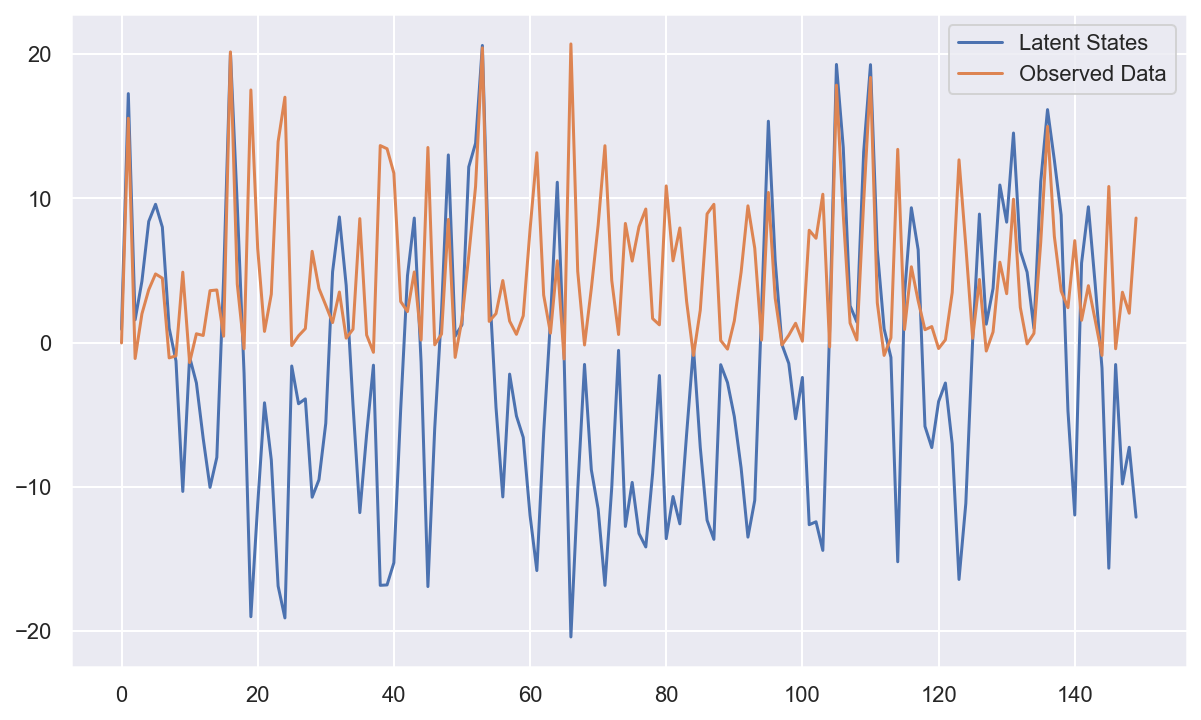

In [214]:
T = 150
x, y = step(T, x_0, marginal = marginal_distribution, transition = transition)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey = True)

sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(x = np.arange(T), y = y, ax = ax, label = "Observed Data")
plt.legend();

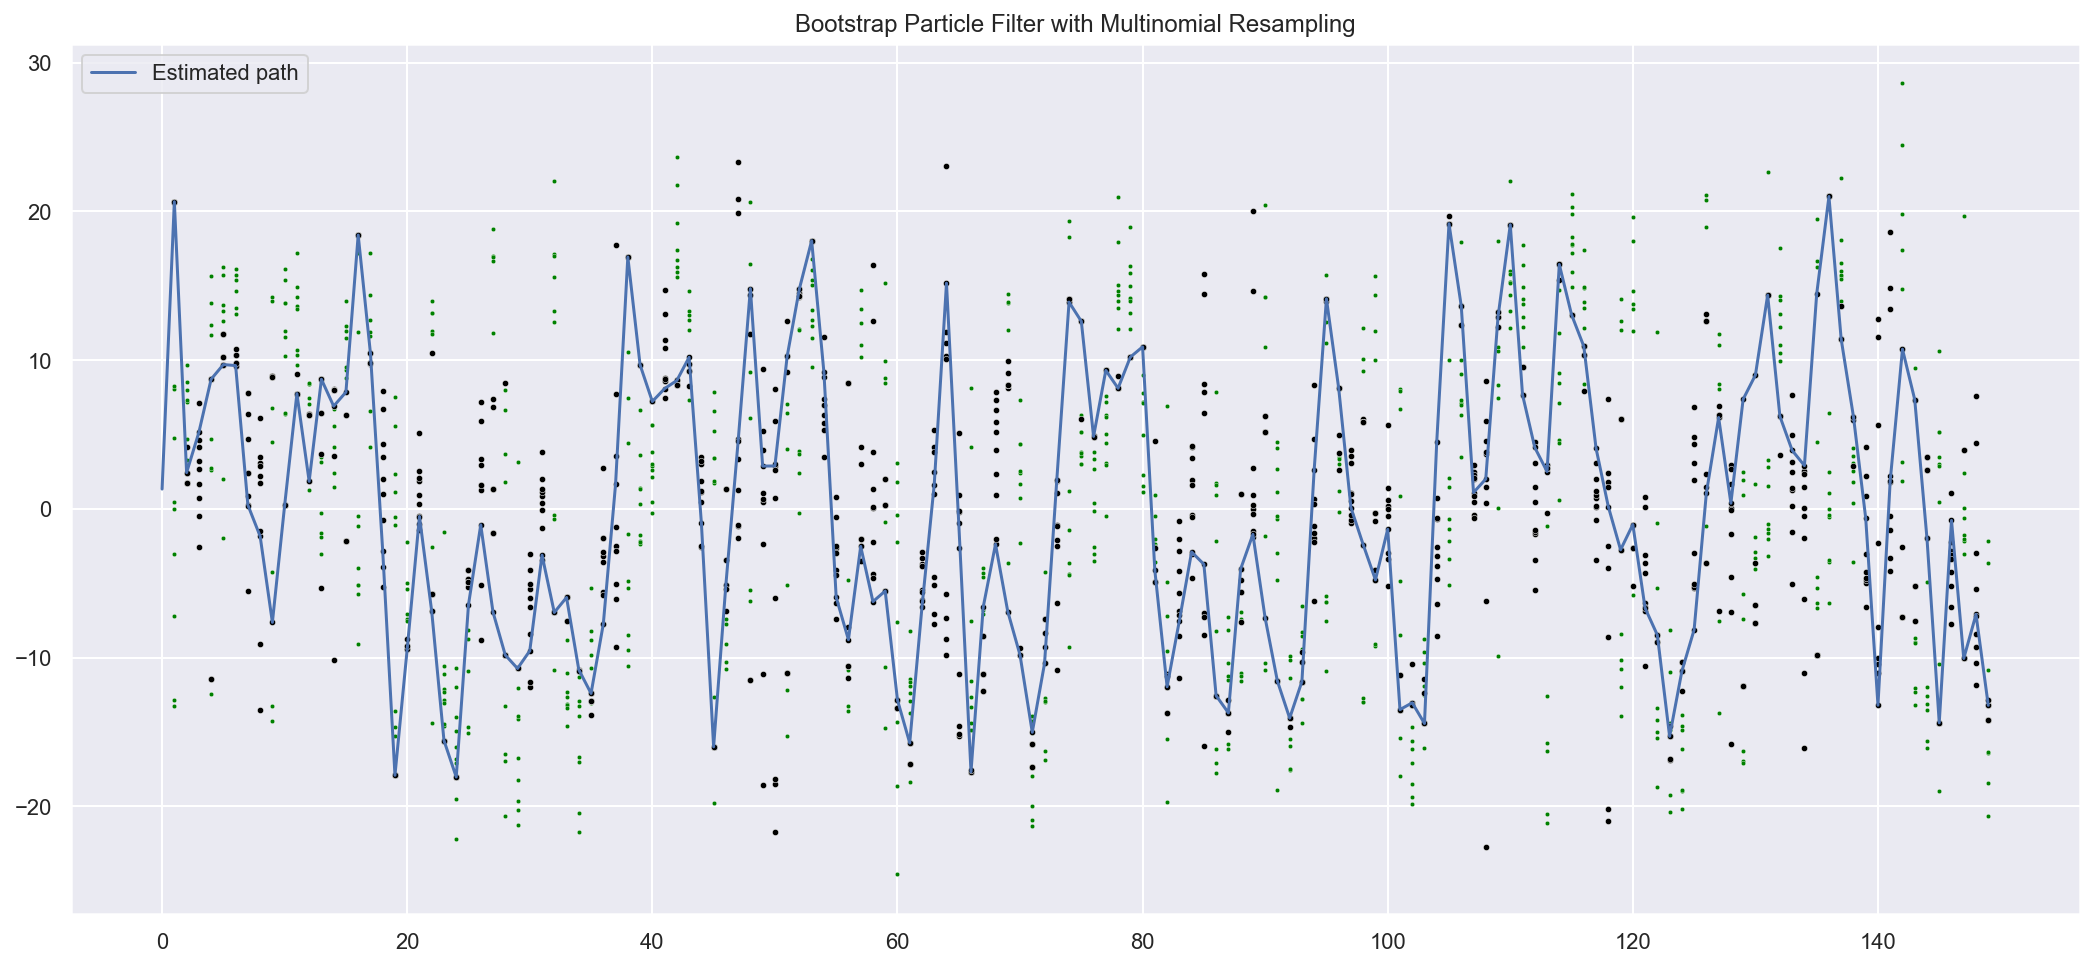

In [230]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharey = True)

N = 10 # num particles
particles = np.zeros((N, T)) # memory for N particles at each timestep
weights = np.ones(N) / N # weight for each particle

# initialization: 
particles[:, 0] = norm(0, np.sqrt(10)).rvs(N)

ind = np.arange(N) # indices of rows of particle matrix
for t in range(1, T):
    # 1) Step forward every x_t (sampling step):
    particles[:, t] = transition(particles[:, t-1], t)
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 5, color = "green")
    
    # 2) Evaluate importance weights and normalize: 
    weights = conditional_marginal(y = y[t], x = particles[:, t])
    weights = np.nan_to_num(weights / np.sum(weights), 0)
    
    # 3) Resample with replacement using weights
    # calculate ESS: 
    ess = 1 / sum(weights**2)
    if ess < (N / 2):
        # multinomial resampling:
        resample_ind = np.random.choice(ind, size = N, p = weights)
        particles = particles[resample_ind, :]
        
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 10, color = "black")

# sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(y = particles[0, :], x = np.arange(T), label = "Estimated path")\
    .set_title("Bootstrap Particle Filter with Multinomial Resampling")
plt.legend();
plt.show();

The transition density is probabilistic, so every time we generate an X, it is different.

#### Note on Resampling

Multinomial resampling is terrible - **why?**

## Jittering Particles

We can jitter the particles at each resampling step to improve the particle impoverishment problem. 

In [231]:
def systematic_resample(weights):
    """ Performs the systemic resampling algorithm used by particle filters.

    This algorithm separates the sample space into N divisions. A single random
    offset is used to to choose where to sample from for all divisions. This
    guarantees that every sample is exactly 1/N apart.
    
    Taken straight from the source code for filterpy: 
    https://filterpy.readthedocs.io/en/latest/_modules/filterpy/monte_carlo/resampling.html#residual_resample
    """
    N = len(weights)

    # make N subdivisions, and choose positions with a consistent random offset
    positions = (random() + np.arange(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

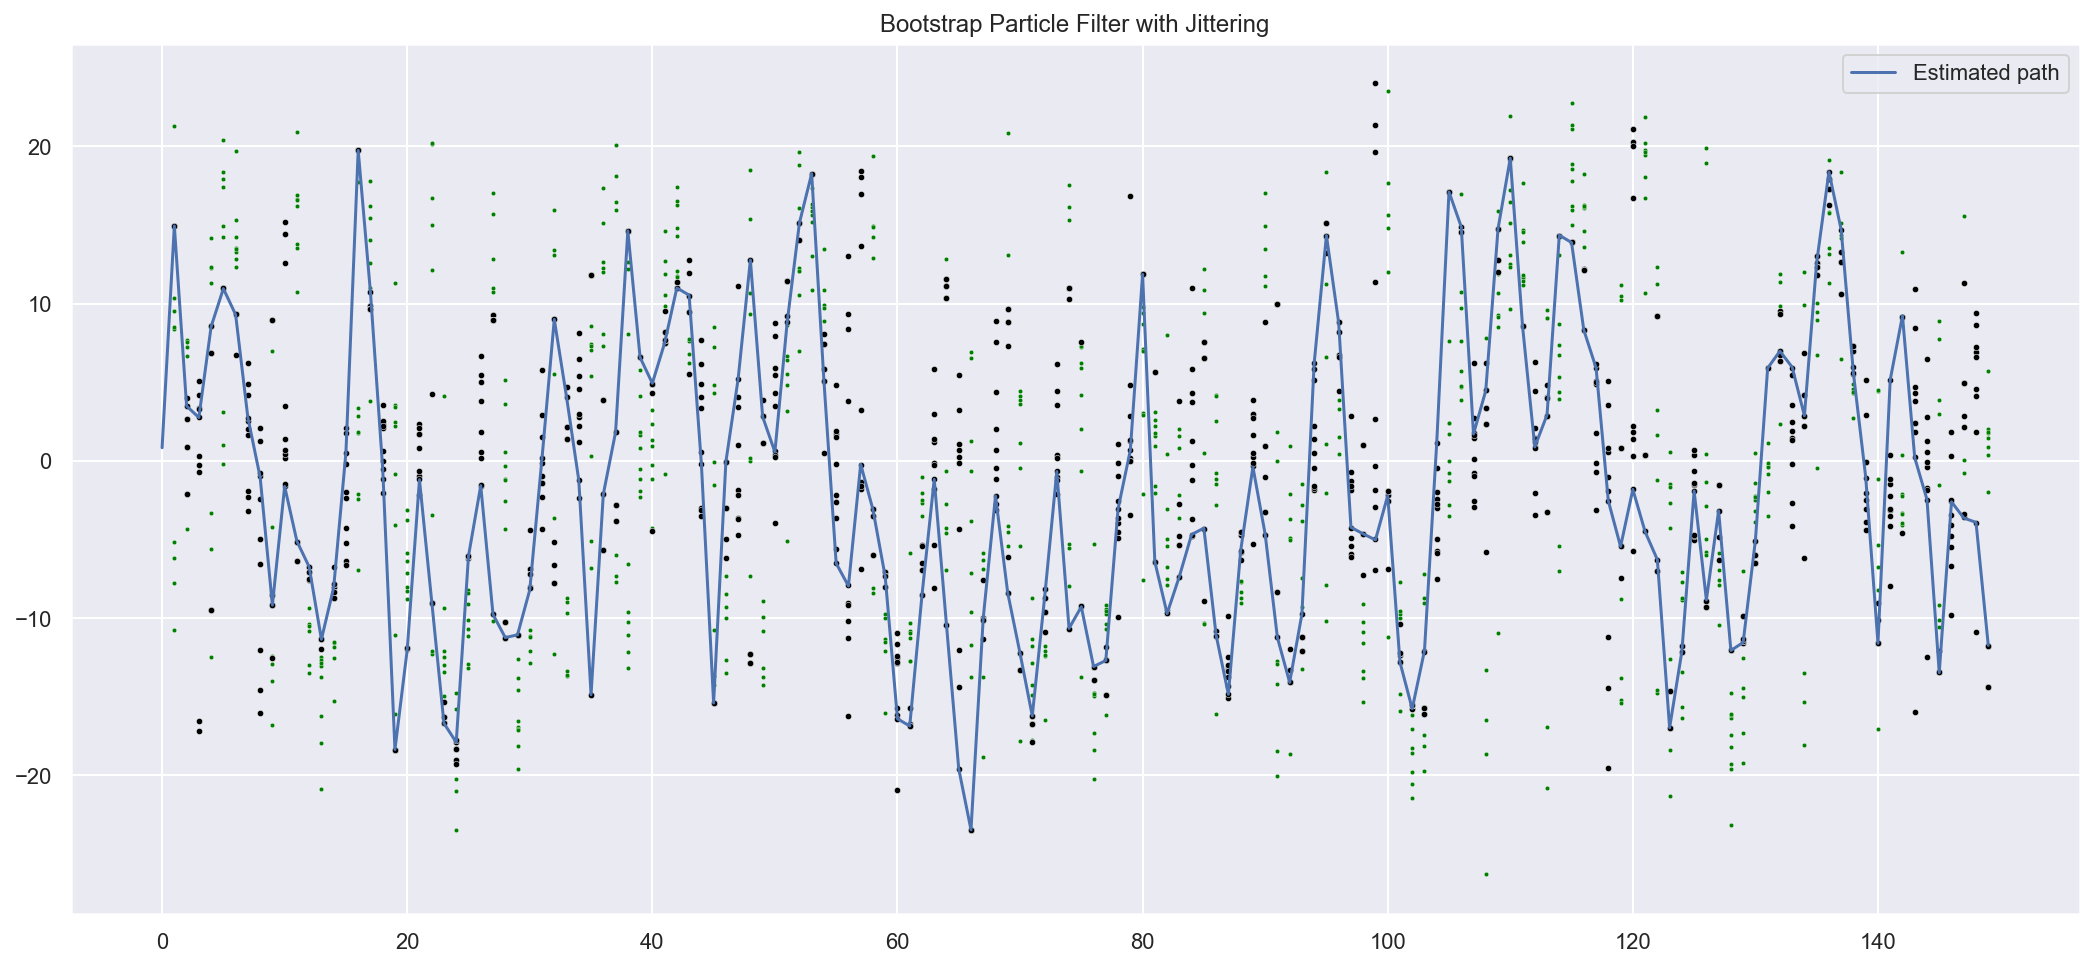

In [229]:
# Particle Filter:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharey = True)

N = 10 # num particles
particles = np.zeros((N, T)) # memory for N particles at each timestep
weights = np.ones(N) / N # weight for each particle

# initialization: 
particles[:, 0] = norm(0, np.sqrt(10)).rvs(N)

ind = np.arange(N) # indices of rows of particle matrix
for t in range(1, T):
    # 1) Step forward every x_t (sampling step):
    particles[:, t] = transition(particles[:, t-1], t)
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 5, color = "green")
    
    # 2) Evaluate importance weights and normalize: 
    weights = conditional_marginal(y = y[t], x = particles[:, t])
    weights = np.nan_to_num(weights / np.sum(weights), 0)
    
    # 3) Resample with replacement using weights
    # calculate ESS: 
    ess = 1 / sum(weights**2)
    if ess < (N / 2):
        # systematic resampling:
        resample_ind = systematic_resample(weights)
        particles = particles[resample_ind, :]
        
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 10, color = "black")
    # 4: Jitter particles
    jitter = norm(loc = 0, scale = 0.03).rvs(N)
    particles[:, t] += jitter

# sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(y = particles[0, :], x = np.arange(T), label = "Estimated path")\
    .set_title("Bootstrap Particle Filter with Jittering")
plt.legend();
plt.show();

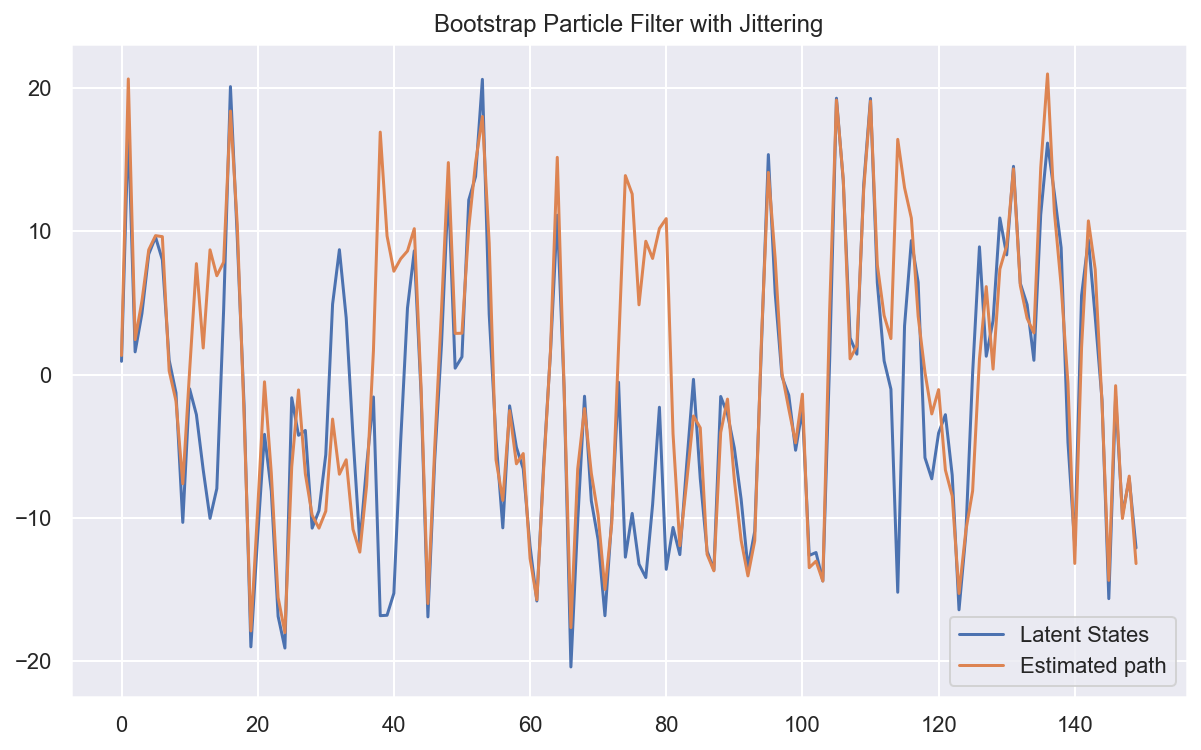

In [232]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey = True)

sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(y = particles[0, :], x = np.arange(T), label = "Estimated path")\
    .set_title("Bootstrap Particle Filter with Jittering")
plt.legend();

## Summarizing Particles with Gaussian Mixture

Can we summarize the particles at each step with a mixture of Gaussians. The GMM can be fit every iteration and we can sample from the GMM instead of storing the particles

Maybe we can use this method for problems where we don't know the transition dynamics. I can compare this method on a probblem that we have transition dynamics for and see how it does. 

Questions: 

* Don't we ignore the transition dynamics if we fit a GMM to the particles? 
* If we ignore the previous particle and only carry around a GMM, how do we update this with the current particle? 
* If we use this on a model where we dont know transition dynamics, do the particles still estimate the log-likelihood? 

How are the particles a consistent estimator of the log-likelihood?



In [ ]:
# Particle Filter:

N = 10 # num particles
particles = np.zeros((N, T)) # memory for N particles at each timestep
weights = np.ones(N) / N # weight for each particle

# initialization: 
particles[:, 0] = norm(0, np.sqrt(10)).rvs(N)

ind = np.arange(N) # indices of rows of particle matrix
for t in range(1, T):
    # 1) Step forward every x_t (sampling step):
    particles[:, t] = transition(particles[:, t-1], t)
    sns.scatterplot(x = t, y = particles[:, t]);
    
    # 2) Evaluate importance weights and normalize: 
    weights = conditional_marginal(y = y[t], x = particles[:, t])
    weights = np.nan_to_num(weights / np.sum(weights), 0)
    
    # 3) Resample with replacement using weights
    # calculate ESS: 
    ess = 1 / sum(weights**2)
    if ess < (N / 2):
#         print("resampling: ", ess)
        resample_ind = np.random.choice(ind, size = N, p = weights)
        particles = particles[resample_ind, :]
        
    # 4: Jitter particles
    jitter = norm(loc = 0, scale = 0.03).rvs(N)
    particles[:, t] += jitter
    
    # 5: Fit GMM
    gm = GaussianMixture(n_components=2, random_state=0).fit(particles)

plt.show();

In [205]:
import numpy as np
from sklearn.mixture import GaussianMixture

X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])

gm = GaussianMixture(n_components=2, random_state=0).fit(X)
gm.means_

gm.predict([[0, 0], [12, 3]])

array([[10.,  2.],
       [ 1.,  2.]])

array([1, 0])

In [206]:
# gm.sample(5)

array([[  0.70322619,  17.66443047,   3.55036531, ...,  10.68894647,
          5.97797974,   4.09192238],
       [  0.70322619,  17.66443047,   3.55036531, ...,  11.35903015,
          4.29756301,  -2.08559771],
       [  0.70322619,  17.66443047,   3.55036531, ...,   9.65186579,
          3.01700741,   4.43684139],
       ...,
       [  0.70322619,  17.66443047,   3.55036531, ...,  11.32561814,
          5.3187624 ,   1.64801055],
       [  0.70322619,  17.66443047,   3.55036531, ...,  10.73000928,
         -0.44247783, -18.42186395],
       [  0.70322619,  17.66443047,   3.55036531, ...,  10.67799403,
         -4.09552096, -22.91083783]])

## Stochastic Volatility

Try to follow [this](https://www.cs.ubc.ca/~arnaud/doucet_johansen_tutorialPF.pdf) writeup 

